## Compressing Data to the IoT Gateway using Autoencoders

Dataset: http://db.csail.mit.edu/labdata/labdata.html

The goal of this project is to reduce the amount of data sent to the gateway layer from edge devices. We use a dataset collected from Intel Labs, and attempt to reduce the size of the data into a form that is a representation of the original data. By reducing the amount of data sent from the sensor to the gateway, we can increase data throughput and decrease network latency.

### Data Loading

In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [43]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]], squeeze=True)
data.columns = ['DATETIME','EPOCH','MOTE_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data = data.set_index('DATETIME')
data.head()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
DATETIME,,,,,,
2004-03-31 03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
2004-02-28 00:59:16.027850,3,1.0,19.9884,37.09330,45.08,2.69964
2004-02-28 01:03:16.333930,11,1.0,19.3024,38.46290,45.08,2.68742
2004-02-28 01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
2004-02-28 01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [44]:
data.describe()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
count,2.313682e+06,2.313156e+06,2.312781e+06,2.312780e+06,2.219804e+06,2.313156e+06
mean,3.303993e+04,2.854412e+01,3.920700e+01,3.390814e+01,4.072110e+02,2.492552e+00
std,1.836852e+04,5.062408e+01,3.741923e+01,1.732152e+01,5.394276e+02,1.795743e-01
min,0.000000e+00,1.000000e+00,-3.840000e+01,-8.983130e+03,0.000000e+00,9.100830e-03
25%,1.757200e+04,1.700000e+01,2.040980e+01,3.187760e+01,3.956000e+01,2.385220e+00
50%,3.332700e+04,2.900000e+01,2.243840e+01,3.928030e+01,1.582400e+02,2.527320e+00
75%,4.778900e+04,4.100000e+01,2.702480e+01,4.358550e+01,5.372800e+02,2.627960e+00
max,6.553500e+04,6.540700e+04,3.855680e+02,1.375120e+02,1.847360e+03,1.856000e+01


We will use sensor data between March 1st and March 15th

In [45]:
data = data.loc['2004-03-01':'2004-03-31']

In [46]:
data.dtypes

EPOCH            int64
MOTE_ID        float64
TEMPERATURE    float64
HUMIDITY       float64
LIGHT          float64
VOLTAGE        float64
dtype: object

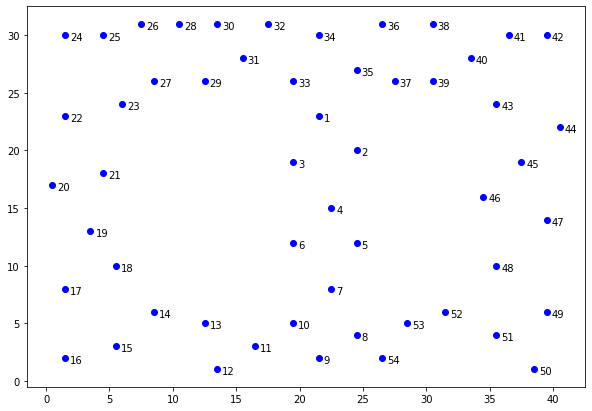

In [47]:
mote_loc_data = pd.read_csv('mote_loc.txt', header=None, sep=' ')
mote_loc_data.columns = ['MOTE_ID', 'X', 'Y']

plt.figure(figsize=(10,7))
plt.scatter(mote_loc_data.X, mote_loc_data.Y, c='blue')
mote_label = [i for i in range(1,len(mote_loc_data)+1)]
for label, x, y in zip(mote_label, mote_loc_data.X, mote_loc_data.Y):
    plt.annotate(
        label, xy=(x,y),
        xytext=(5, -5),
        textcoords='offset points'
    )

### Data Cleanup

In [48]:
data.isna().sum()

EPOCH              0
MOTE_ID          275
TEMPERATURE      353
HUMIDITY         354
LIGHT          86658
VOLTAGE          275
dtype: int64

In [49]:
data.corr()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
EPOCH,1.000000,0.005392,0.279826,-0.160902,0.041259,-0.631027
MOTE_ID,0.005392,1.000000,-0.014565,0.090979,0.109979,-0.000465
TEMPERATURE,0.279826,-0.014565,1.000000,-0.688070,0.010626,-0.744604
HUMIDITY,-0.160902,0.090979,-0.688070,1.000000,-0.080524,0.480602
LIGHT,0.041259,0.109979,0.010626,-0.080524,1.000000,0.078339
VOLTAGE,-0.631027,-0.000465,-0.744604,0.480602,0.078339,1.000000


First, consider the MOTE_ID. If the mote_id is null, then clearly their is either a misreading or the dataset has errors. We can sefely drop these datapoints since they have no observation data, nor do they give information on what sensor is doing the reading. Likewise, we can eliminate all data from sensors labeled > 54, as there are only 54 sensors in our array.

In [50]:
data.dropna(subset=['MOTE_ID'], inplace=True)
data = data[data.MOTE_ID <= len(mote_loc_data)].copy()

We can also make MOTE_ID an integer, since it is a unique identifier for a sensor.

In [51]:
data.MOTE_ID = data.MOTE_ID.astype(int)
data.dtypes

EPOCH            int64
MOTE_ID          int64
TEMPERATURE    float64
HUMIDITY       float64
LIGHT          float64
VOLTAGE        float64
dtype: object

We can remove values where temperature readings are unreasonable.

In [52]:
data = data[(data.TEMPERATURE >= -5) & (data.TEMPERATURE <= 50)].copy()

Next, we use linear interpolation to fill in blank values.

In [53]:
data.LIGHT = data.LIGHT.interpolate()
data.TEMPERATURE = data.TEMPERATURE.interpolate()
data.HUMIDITY = data.HUMIDITY.interpolate()
data.VOLTAGE = data.VOLTAGE.interpolate()
data.isna().sum()

EPOCH          0
MOTE_ID        0
TEMPERATURE    0
HUMIDITY       0
LIGHT          0
VOLTAGE        0
dtype: int64

Our data is now merged and we have a clean set to work with.

In [54]:
data.describe()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
count,1.714223e+06,1.714223e+06,1.714223e+06,1.714223e+06,1.714223e+06,1.714223e+06
mean,3.298180e+04,2.884696e+01,2.245408e+01,3.923228e+01,4.057393e+02,2.543088e+00
std,1.706122e+04,1.514509e+01,3.955246e+00,9.958647e+00,5.476523e+02,1.171380e-01
min,0.000000e+00,1.000000e+00,-4.227400e+00,-8.983130e+03,0.000000e+00,3.468550e-02
25%,1.872700e+04,1.700000e+01,2.030200e+01,3.509150e+01,3.374889e+01,2.464400e+00
50%,3.085100e+04,2.900000e+01,2.194840e+01,4.043280e+01,1.508800e+02,2.560000e+00
75%,4.610100e+04,4.200000e+01,2.387900e+01,4.401760e+01,5.529438e+02,2.627960e+00
max,6.553500e+04,5.400000e+01,4.999600e+01,1.148940e+02,1.847360e+03,2.911370e+00


Here is a visualization on our observable variables.

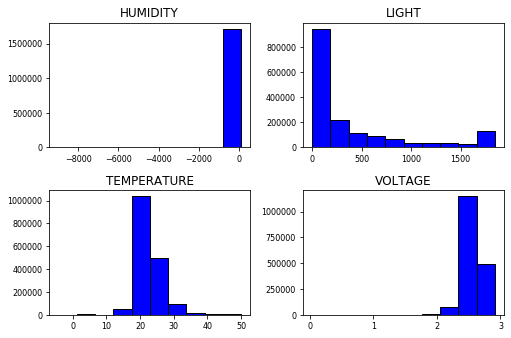

In [55]:
data[['TEMPERATURE', 'HUMIDITY', 'LIGHT', 'VOLTAGE']].hist(bins=10, color='blue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))  

Here are the Box and Whisker plots for the observable values, further illustrating outliers.

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
data.boxplot(column='TEMPERATURE', ax=axes[0,0])
data.boxplot(column='HUMIDITY', ax=axes[0,1])
data.boxplot(column='LIGHT', ax=axes[1,0])
data.boxplot(column='VOLTAGE', ax=axes[1,1])
plt.show()

### Data Splitting